In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy import signal
import random
from scipy.optimize import curve_fit

import h5py
from IPython.utils import io

In [9]:
import sys
sys.path.append("/home/nadavp/new_trap/Tools/")
sys.path.append('/home/nadavp/new_trap/Tools/StatFramework/')
import BeadDataFile
from discharge_tools import *

In [10]:
from likelihood_calculator import likelihood_analyser
from likelihood_calculator import GravityFramework
from likelihood_calculator import auxiliary_functions as aux
gfw = GravityFramework.GravityFramework()

sys.path.append('/home/analysis_user/New_trap_code/SensitivityFramework/')
from signal_model_utilities import *

In [11]:
ll = likelihood_analyser.LikelihoodAnalyser()
gfw = GravityFramework.GravityFramework()

### Loading force calibration and transfer function

In [12]:
bdf_discharge = load_dir(dirname='/data/new_trap/20200614/Bead1/Discharge/Discharge3/', start_file=50, max_file=15)

bdf_z = bdf_discharge[10:]
bdf_x = bdf_discharge[:5]
bdf_y = bdf_discharge[5:10]

305  files in folder
15  files loaded


In [13]:
fname = r'/data/new_trap/20200614/Bead1/TransFunc/TransFunc_X_2_7e5_250s_1Hz.h5'
tf_x = BeadDataFile.BeadDataFile(fname)
fname = r'/data/new_trap/20200614/Bead1/TransFunc/TransFunc_Y_2_7e5_250s_1Hz.h5'
tf_y = BeadDataFile.BeadDataFile(fname)
fname = r'/data/new_trap/20200614/Bead1/TransFunc/TransFunc_Z_2_7e5_250s_1Hz.h5'
tf_z = BeadDataFile.BeadDataFile(fname)

gfw.build_transfer_function([tf_x, tf_y, tf_z], base_freq=1, number_of_harmonics=90, scale_freq=71, plot=False)

No height data
No cantilever data
Error loading spinning data
No laser power data
No height data
No cantilever data
Error loading spinning data
No laser power data
No height data
No cantilever data
Error loading spinning data
No laser power data


In [14]:
freq1 = tf_x.psd2('x')[0]
x_scale_71 = 1/np.sqrt(tf_x.psd2('x')[1][freq1==71])
y_scale_71 = 1/np.sqrt(tf_y.psd2('y')[1][freq1==71])
z_scale_71 = 1/np.sqrt(tf_z.psd2('z')[1][freq1==71])

bandwidth=1
m1_zscale = gfw.build_z_response(bdf_z, drive_freq=71, charges=3, bandwidth=bandwidth, decimate=10)

***************************************************
Z2-amplitude:  2.84e+02
reduced chi2:  152.39069369523384
***************************************************
Z2-amplitude:  2.88e+02
reduced chi2:  574.6962309868719
***************************************************
Z2-amplitude:  2.85e+02
reduced chi2:  548.9691574928959
***************************************************
Z2-amplitude:  2.84e+02
reduced chi2:  425.28581319301475
***************************************************
Z2-amplitude:  2.93e+02
reduced chi2:  429.2547764480599
Z2 response (amplitude): 286.6277458393116


### Profile Likelihood

In [50]:
data_bdfs2 = load_dir(dirname='/data/new_trap/20200614/Bead1/Shaking/Shaking367/',
                         file_prefix='NoSpinNoShaking0', start_file=0, max_file=10)

1000  files in folder
10  files loaded


In [51]:
## force template - you can change it as you like
dist = 10
z_sep = -10
y_offset = 0
test_shaking378 = force_vs_time(dist*1e-6,z_sep*1e-6,200e-6,3,"x",100e-6, yuk_or_grav="yuk",offset_y=y_offset*1e-6, 
                     alpha=1e8, bead_size=3.8e-6)
shaking378_template = np.array(test_shaking378[1])*1.85/1.55 ## the extra correction is for the density

Your choice of lambda is not existing
Taking 1.00e-04 for lambda
order
A bead size of 3.80e-06 is selected
3.8e-06
3.8e-06
A bead size of 3.80e-06 is selected
3.8e-06
posvec
A bead size of 3.80e-06 is selected
3.8e-06
A separation of 1.00e-05 is selected
A height of -1.00e-05 is selected


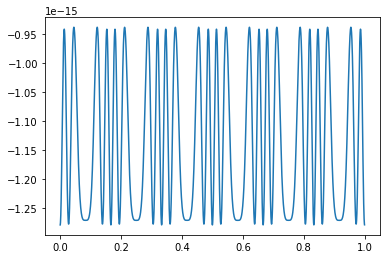

In [32]:
plt.plot(test_shaking378[0],test_shaking378[1])

In [45]:
## harmonics and their relative scale
gravity_freqs = np.array([36, 33, 42, 18, 21,39,24]) ## frequencies to be used
gravity_scales = np.array([gfw.scale_Z2])* np.interp(gravity_freqs, gfw.tf_freq, gfw.tf_ffts[0])*(z_scale_71/x_scale_71)

In [46]:
gravity_scales

array([5.13056958e+10, 3.98638210e+10, 4.70449871e+10, 5.20787117e+10,
       3.78785721e+10, 4.62257422e+10, 4.55905526e+10])

In [47]:
## building noise array - each harmoincs has it's own noise std
noises = []
noises_std =[]
for freq_ in gravity_freqs:
    tmp_list = []
    for bb in data_bdfs2:
        tmp_list.append(np.std(bb.response_at_freq2('x', drive_freq=freq_, bandwidth=bandwidth)))
    noises.append(np.mean(tmp_list))
    noises_std.append(np.std(tmp_list))
noises = np.array(noises)
noises_std = np.array(noises_std)

In [48]:
from multiprocessing import Pool

def func2(i):
    print(i,'  ******************')
#     fname = r'/data/new_trap/20200614/Bead1/Shaking/Shaking367/SpinShaking4_'+str(i)+'.h5'
#     bb = BeadDataFile.BeadDataFile(fname=fname)

    fname = r'/data/new_trap/20200614/Bead1/Shaking/Shaking367/NoSpinNoShaking0_'+str(i)+'.h5'
    bb = BeadDataFile.BeadDataFile(fname=fname)
    
    fit_kwargs = {'A': 0, 'phi': 0.2, 'sigma':10.7,
              'error_A': 0.1, 'error_phi': 0.5, 'errordef': 1, 'error_sigma': 10,
              'limit_phi': [0, 2 * np.pi],
              'limit_A': [-1000, 1000], 'limit_sigma': [0, 1000000],
              'print_level': 0, 'fix_A': False, 'fix_phi': True, 'fix_sigma': True}
    mm_tmp = ll.find_mle_multiHarmoincs(x=bb.x2, template=shaking378_template, scales=gravity_scales, 
                                          signal_freqs=gravity_freqs, bandwidth=bandwidth, noises=noises_std/noises_std[0],
                                          decimate=10, **fit_kwargs)
    return mm_tmp.values[0]
    
if __name__ == '__main__':
    pool = Pool(processes=20)                         # Create a multiprocessing Pool
    mm_mle_spin4 = np.array(pool.map(func2, range(0,100)))
    pool.close()

0   ******************
2   ******************
24   ******************
8   ******************
12   ******************
26   ******************
4   ******************
20   ******************
18   ******************
6   ******************
10   ******************
22   ******************
14   ******************
32   ******************
16   ******************
36   ******************
30   ******************
28   ******************
38   ******************
34   ******************
39   ******************
17   ******************
29   ******************
15   ******************
3   ******************
31   ******************
11   ******************
35   ******************
9   ******************
23   ******************
13   ******************
5   ******************
21   ******************
33   ******************
37   ******************
19   ******************
27   ******************
25   ******************
7   ******************
1   ******************
40   ******************
42   ******************
44

In [49]:
#The estimation of the limit for 1000 datafiles with the above settings is  
print('{:.2e}'.format(np.std(mm_mle_spin4)/np.sqrt(1000)*2))

7.70e-02


###  Limit

In [52]:
num_points = 30
L = np.logspace(0.5, 3, num_points)*1e-6  ## lambda

In [53]:
limit = []
for lam_num,Lam in enumerate(L):
    
    print('**************************************')
    print(lam_num,'/',num_points)
    print('**************************************')
    
    dist = 1
    z_sep = -1
    y_offset = 0
    test_shaking378 = force_vs_time(dist*1e-6,z_sep*1e-6,200e-6,3,"x",Lam, yuk_or_grav="yuk",offset_y=y_offset*1e-6, 
                     alpha=1e8, bead_size=3.8e-6)
    shaking378_template = np.array(test_shaking378[1])*1.85/1.55 ## the extra correction is for the density
    
    def func3(i):
        fname = r'/data/new_trap/20200614/Bead1/Shaking/Shaking367/NoSpinNoShaking0_'+str(i)+'.h5'
        bb = BeadDataFile.BeadDataFile(fname=fname)

        fit_kwargs = {'A': 0, 'phi': 0.2, 'sigma':10.7,
                  'error_A': 1, 'error_phi': 0.5, 'errordef': 1, 'error_sigma': 10,
                  'limit_phi': [0, 2 * np.pi],
                  'limit_A': [-1000, 1000], 'limit_sigma': [0, 1000000],
                  'print_level': 0, 'fix_A': False, 'fix_phi': True, 'fix_sigma': True}
        mm_tmp = ll.find_mle_multiHarmoincs(x=bb.x2, template=shaking378_template, scales=gravity_scales, 
                                              signal_freqs=gravity_freqs, bandwidth=bandwidth, noises=noises_std/noises_std[0],
                                              decimate=10, **fit_kwargs)
        #print(len(bb.x2))
        return mm_tmp.values[0]
    
    if __name__ == '__main__':
        pool = Pool(processes=20)                         # Create a multiprocessing Pool
        mm_mle_spin4 = np.array(pool.map(func3, range(0,100)))
        limit.append(np.std(mm_mle_spin4)/np.sqrt(1000)*2)
        pool.close()

**************************************
0 / 30
**************************************
Your choice of lambda is not existing
Taking 3.16e-06 for lambda
order
A bead size of 3.80e-06 is selected
3.8e-06
3.8e-06
A bead size of 3.80e-06 is selected
3.8e-06
posvec
A bead size of 3.80e-06 is selected
3.8e-06
A separation of 1.00e-06 is selected
A height of -1.00e-06 is selected
**************************************
1 / 30
**************************************
Your choice of lambda is not existing
Taking 3.98e-06 for lambda
order
A bead size of 3.80e-06 is selected
3.8e-06
3.8e-06
A bead size of 3.80e-06 is selected
3.8e-06
posvec
A bead size of 3.80e-06 is selected
3.8e-06
A separation of 1.00e-06 is selected
A height of -1.00e-06 is selected
**************************************
2 / 30
**************************************
Your choice of lambda is not existing
Taking 4.64e-06 for lambda
order
A bead size of 3.80e-06 is selected
3.8e-06
3.8e-06
A bead size of 3.80e-06 is selected
3.8e-06


**************************************
22 / 30
**************************************
Your choice of lambda is not existing
Taking 2.51e-04 for lambda
order
A bead size of 3.80e-06 is selected
3.8e-06
3.8e-06
A bead size of 3.80e-06 is selected
3.8e-06
posvec
A bead size of 3.80e-06 is selected
3.8e-06
A separation of 1.00e-06 is selected
A height of -1.00e-06 is selected
**************************************
23 / 30
**************************************
Your choice of lambda is not existing
Taking 2.93e-04 for lambda
order
A bead size of 3.80e-06 is selected
3.8e-06
3.8e-06
A bead size of 3.80e-06 is selected
3.8e-06
posvec
A bead size of 3.80e-06 is selected
3.8e-06
A separation of 1.00e-06 is selected
A height of -1.00e-06 is selected
**************************************
24 / 30
**************************************
Your choice of lambda is not existing
Taking 3.69e-04 for lambda
order
A bead size of 3.80e-06 is selected
3.8e-06
3.8e-06
A bead size of 3.80e-06 is selected
3.8e-

In [54]:
limit

[0.07545637294981726,
 0.04797867965364675,
 0.03731411376374915,
 0.027390777653908804,
 0.02321467892620811,
 0.019097791350063273,
 0.01657317319937141,
 0.015445706871913828,
 0.014293592316679772,
 0.013773970127719193,
 0.013240571199685927,
 0.012999466030745864,
 0.012751808124711491,
 0.01259551172033354,
 0.012524859437480254,
 0.012452294124634364,
 0.012419492273991676,
 0.0123858024332023,
 0.012364542936594308,
 0.012354933322004677,
 0.01234506407022476,
 0.012340603184146603,
 0.0123360219067382,
 0.012333951228542398,
 0.012331824700908385,
 0.012330482941195115,
 0.012329876489479431,
 0.012329253688661002,
 0.012328972213459974,
 0.012328683109505148]

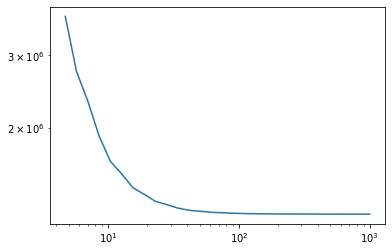

In [55]:
plt.loglog(L[2:]*1e6,np.array(limit[2:])*1e8)

In [273]:
def fft_norm(N, fsamp):
    return np.sqrt(2 / (N * fsamp))

In [ ]:
length = 5000
#r = np.random.normal(0.01035461316861217,0.0016133366256926133,length)
r=np.random.normal(0,1e-17,length)
fft = np.abs(np.fft.rfft(r))
freq3 = np.fft.rfftfreq(length, d=1./5000)
ps = fft*fft.conj().real*fft_norm(length,5000)**2


In [ ]:
np.mean(np.sqrt(ps))

In [413]:
fname = r'/data/new_trap/20200614/Bead1/Shaking/Shaking367/NoSpinNoShaking0_'+"5"+'.h5'
bb = BeadDataFile.BeadDataFile(fname=fname)

In [428]:
np.shape(bb.x2)

(50000,)

In [ ]:
limit2 = []
for lam_num,Lam in enumerate(L):
    
    print('**************************************')
    print(lam_num,'/',num_points)
    print('**************************************')
    
    dist = 1
    z_sep = -1
    y_offset = 0
    test_shaking378 = force_vs_time(dist*1e-6,z_sep*1e-6,200e-6,3,"x",Lam, yuk_or_grav="yuk",offset_y=y_offset*1e-6, 
                     alpha=1e8, bead_size=3.8e-6)
    shaking378_template = np.array(test_shaking378[1])*1.85/1.55 ## the extra correction is for the density
    
    def func3(i):
        fname = r'/data/new_trap/20200614/Bead1/Shaking/Shaking367/NoSpinNoShaking0_'+str(i)+'.h5'
        bb = BeadDataFile.BeadDataFile(fname=fname)

        fit_kwargs = {'A': 0, 'phi': 0.2, 'sigma':10.7,
                  'error_A': 1, 'error_phi': 0.5, 'errordef': 1, 'error_sigma': 10,
                  'limit_phi': [0, 2 * np.pi],
                  'limit_A': [-1000, 1000], 'limit_sigma': [0, 1000000],
                  'print_level': 0, 'fix_A': False, 'fix_phi': True, 'fix_sigma': False}
        mm_tmp = ll.find_mle_multiHarmoincs(x=r, template=shaking378_template, scales=gravity_scales, 
                                              signal_freqs=gravity_freqs, bandwidth=bandwidth, noises=noises_std/noises_std[0],
                                              decimate=10, **fit_kwargs)
        #print(len(bb.x2))
        return mm_tmp.values[0]
    
    if __name__ == '__main__':
        pool = Pool(processes=20)                         # Create a multiprocessing Pool
        mm_mle_spin4 = np.array(pool.map(func3, range(0,100)))
        limit2.append(np.std(mm_mle_spin4)/np.sqrt(1000)*2)
        pool.close()

**************************************
0 / 30
**************************************
Your choice of lambda is not existing
Taking 3.16e-06 for lambda
order
A bead size of 3.80e-06 is selected
3.8e-06
3.8e-06
A bead size of 3.80e-06 is selected
3.8e-06
posvec
A bead size of 3.80e-06 is selected
3.8e-06
A separation of 1.00e-06 is selected
A height of -1.00e-06 is selected


In [ ]:
plt.loglog(L[2:]*1e6,np.array(limit[2:])*1e8)
plt.loglog(L[2:]*1e6,np.array(limit2[2:])*1e8)

In [125]:
np.divide(limit2,limit)


array([ 6.21336674, 10.82780136,  3.17422619,  4.37595658,  5.60923979,
        4.47777626,  4.20662411,  4.35925921,  5.25499289,  5.27825753,
        6.13777101,  6.04106115,  6.18013713,  6.5764106 ,  6.70592853,
        6.33025561,  6.72776653,  6.27204456,  5.85003609,  5.6304093 ,
        5.90492547,  5.69326994,  5.85546145,  5.47710802,  5.79791432,
        5.88082681,  6.05727689,  5.49567555,  5.57610371,  5.63275812])

In [126]:
np.sqrt(100)

10.0